In [12]:

from dwdynamics import ComplexDynamicsProblem, Objective,helpers,fixed_point,instance # Difference a. We are using ComplexDynamicsProblem
from dimod import ExactSolver
import numpy as np
import scipy
import pandas as pd
import numpy as np
import scipy as sp
import math
import qutip as qp
import dimod
import pandas as pd
from collections import defaultdict
import re
from dwave.system import DWaveSampler, EmbeddingComposite, TilingComposite,ParallelEmbeddingComposite
import dwave.inspector
import matplotlib.pyplot as plt

In [90]:
# Let's compute baseline using QuTiP
import qutip as qp

#instance = 8
#PSI0_2 = np.array([1,0,0,0],dtype=np.complex128)
#instance_dict = helpers.get_instance(instance)
#H = instance_dict['H']
#PSI0 = instance_dict['psi0']

#i = instance.Instance(1)
#i.create_instance(precision=2,number_time_points=2)
H = np.pi/3*1/np.sqrt(3)*np.matrix([[1,1-1j],[1+1j,-1]])
#H =np.kron(np.eye(2),H)
problem =ComplexDynamicsProblem(H,np.array([1,0]),[0,1],2)
qubo = problem.qubo(objective=Objective.hessian)



[[ 2. +0.j   0. +0.j  -0.5-0.5j -0.5-0.5j]
 [ 0. +0.j   2. +0.j   0.5-0.5j -0.5+0.5j]
 [-0.5+0.5j  0.5+0.5j  1. +0.j   0. +0.j ]
 [-0.5+0.5j -0.5-0.5j  0. +0.j   1. +0.j ]]
[[ 2.   0.   0.   0.  -0.5 -0.5 -0.5 -0.5]
 [-0.   2.  -0.   0.   0.5 -0.5  0.5 -0.5]
 [ 0.   0.   2.   0.   0.5 -0.5 -0.5  0.5]
 [-0.   0.  -0.   2.   0.5  0.5 -0.5 -0.5]
 [-0.5  0.5  0.5  0.5  1.   0.   0.   0. ]
 [-0.5 -0.5 -0.5  0.5 -0.   1.  -0.   0. ]
 [-0.5  0.5 -0.5 -0.5  0.   0.   1.   0. ]
 [-0.5 -0.5  0.5 -0.5 -0.   0.  -0.   1. ]]


In [77]:
exact_solver = ExactSolver()            
exact_result = exact_solver.sample(qubo)      
print(exact_result.first.energy)

psi_0 = qp.basis(2, 0)


# Define sigma_z for manual computation of expected values
SZ = np.array([[1, 0], [0, -1]])

# decode_sample returns flat vector, we use reshape to form an 6x2 array of states
exact_vec = problem.interpret_sample(exact_result.first.sample)

# Difference d.: We use complex conjugation to compute expected values. For this example it shouldn't matter though.
# Then, for the expectation values we take only the real part, because otherwise matplotlib would complain.
exact_expect = [(state.conj() @ SZ @ state).real for state in exact_vec]
from matplotlib import pyplot as plt
print(exact_expect)

MemoryError: Unable to allocate 2.25 TiB for an array with shape (68719476736, 36) and data type int8

In [15]:
helpers.result_string_to_dict('111000')

{0: 1, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0}

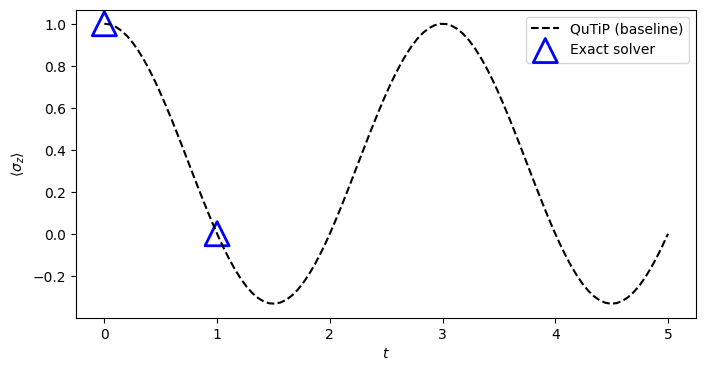

In [91]:
fig, axis = plt.subplots(figsize=(8, 4))
times = np.linspace(0, 5, 100)
baseline = qp.mesolve(qp.Qobj(H), psi_0, times, e_ops=[qp.sigmaz()]).expect[0]
axis.plot(times, baseline, "k--", label="QuTiP (baseline)")

axis.scatter(problem.times, exact_expect, marker="^", lw=2, s=300, edgecolors="b", facecolors="none", label="Exact solver")

axis.set_ylabel(r"$\langle \sigma_z \rangle$")
axis.set_xlabel("$t$")
axis.legend()
plt.show()

In [92]:
dw_sampler = EmbeddingComposite(DWaveSampler(solver="Advantage_system6.4"))

dw_result = dw_sampler.sample(qubo, num_reads=1000, annealing_time=200)
dwave.inspector.show(dw_result)

Serving Inspector on http://127.0.0.1:18000/?problemId=39694154-ba75-46cd-bc26-451fc327aaf0

'http://127.0.0.1:18000/?problemId=39694154-ba75-46cd-bc26-451fc327aaf0'

In [85]:
times = np.linspace(0, len(problem.times), 100)
baseline = qp.mesolve(qp.Qobj(problem.hamiltonian), qp.Qobj(problem.initial_state), times, e_ops=[qp.sigmaz()]).expect[0]

# Define sigma_z for manual computation of expected values

SZ = np.array([[1, 0], [0, -1]])

final_dict= defaultdict(list)
for sample in dw_result.samples(30):
    for key, value in sample.items():
        final_dict[key].append(value)
for key, value in final_dict.items():
    print(len(value))
    final_dict[key] = 1 if sum(value) > len(value) /2 else 0 
print(final_dict)
for sample in dw_result.samples(5):
    dw_vec = problem.interpret_sample(final_dict)
    dw_expect = [(state.conj() @ SZ @ state).real for state in dw_vec]
    fig, axis = plt.subplots(figsize=(8, 4))

    axis.plot(times, baseline, "k--", label="QuTiP (baseline)")

    #axis.scatter(inst_obj.problem.times, exact_expect, marker="^", lw=2, s=300, edgecolors="b", facecolors="none", label="Exact solver")
    #axis.scatter(problem.times, sa_expect, marker="o", lw=2, s=100, edgecolors="r", facecolors="none", label="SA sampler")
    axis.scatter(problem.times, dw_expect, marker="s", lw=2, s=200, label="D-Wave sampler")
axis.set_title(f"System {system}")
axis.set_ylabel(r"$\langle \sigma_z \rangle$")
axis.set_xlabel("$t$")
axis.legend()
dw_result.samples(5)

ValueError: incompatible dimensions [2] and [4]

In [17]:
df = i.get_xubo_df()

for _,(energy,state) in df.head(10).iterrows():
    print(energy)
    sample_vec = i.problem.interpret_sample(helpers.result_string_to_dict(state))
    print(sample_vec)
    exact_expect = [(state.conj() @ SZ @ state).real for state in sample_vec]
    print(exact_expect)
    print("---------")

    

-42.0
[[1.+0.j 1.+1.j]
 [1.+1.j 1.+0.j]]
[np.float64(-1.0), np.float64(1.0)]
---------
-41.0
[[1.-1.j 1.+1.j]
 [1.+1.j 1.+1.j]]
[np.float64(0.0), np.float64(0.0)]
---------
-41.0
[[1.+1.j 1.+1.j]
 [1.+1.j 1.+1.j]]
[np.float64(0.0), np.float64(0.0)]
---------
-41.0
[[ 1.+0.j -1.+1.j]
 [ 0.+1.j  1.+0.j]]
[np.float64(-1.0), np.float64(0.0)]
---------
-41.0
[[ 1.+0.j  0.+1.j]
 [-1.+1.j  1.+0.j]]
[np.float64(0.0), np.float64(1.0)]
---------
-41.0
[[1.+0.j 1.-1.j]
 [1.+0.j 1.+0.j]]
[np.float64(-1.0), np.float64(0.0)]
---------
-41.0
[[1.+0.j 1.+0.j]
 [1.-1.j 1.+0.j]]
[np.float64(0.0), np.float64(1.0)]
---------
-41.0
[[-1.+0.j  1.+1.j]
 [ 1.+1.j -1.+0.j]]
[np.float64(-1.0), np.float64(1.0)]
---------
-41.0
[[0.+0.j 1.+1.j]
 [1.+1.j 0.+0.j]]
[np.float64(-2.0), np.float64(2.0)]
---------
-41.0
[[2.+0.j 1.+1.j]
 [1.+1.j 0.+0.j]]
[np.float64(2.0), np.float64(2.0)]
---------


In [18]:
state = 1/math.sqrt(2) * np.array([1,1])
print(state)
state= np.array([3/5,4/5])
(state.conj() @ SZ @ state).real

[0.70710678 0.70710678]


np.float64(-0.28000000000000014)

# Analyze Velox results

In [19]:
system=9
df = pd.read_csv(f'../data/results/norm/{system}/best_results_pruned_{system}_native.csv')
df

,type,instance,num_var,num_rep,num_steps,compress,runtime,gap,best_energy,gnd_energy,success_prob,best_solution
0,9,precision_5_timepoints_2.coo,40,16,1000,False,0.045563,0.494676,-70.682426,-71.033814,0.000000,-1;1;-1;1;1;-1;1;-1;1;1;-1;1;-1;1;-1;-1;1;-1;1...
1,9,precision_5_timepoints_3.coo,60,16,1000,False,0.030310,0.303082,-125.527206,-125.908814,0.000000,-1;1;1;1;1;-1;1;-1;1;1;-1;1;-1;1;1;-1;-1;1;-1;...
2,9,precision_5_timepoints_4.coo,80,16,1000,False,0.167330,0.357086,-180.138260,-180.783814,0.000000,-1;1;1;1;1;-1;-1;1;1;1;-1;1;-1;-1;1;-1;-1;1;-1...
3,9,precision_6_timepoints_2.coo,48,16,1000,False,0.037726,0.376368,-72.672890,-72.947441,0.000000,-1;-1;1;1;1;1;-1;1;-1;1;1;-1;-1;1;-1;-1;1;1;-1...
4,9,precision_6_timepoints_3.coo,72,16,1000,False,0.026704,0.461892,-128.445160,-129.041191,0.000000,1;-1;1;-1;-1;-1;-1;1;1;1;-1;1;1;-1;-1;-1;-1;1;...
...,...,...,...,...,...,...,...,...,...,...,...,...
592,9,precision_7_timepoints_3.coo,84,262144,1000000,False,1871.928448,0.003764,-130.627853,-130.632770,0.726318,1;-1;-1;1;1;-1;1;-1;1;-1;-1;-1;-1;-1;-1;-1;1;1...
593,9,precision_7_timepoints_4.coo,112,262144,1000000,False,1926.038573,0.006770,-187.332977,-187.345661,0.543976,1;-1;-1;-1;-1;1;-1;-1;1;-1;-1;-1;-1;1;-1;1;-1;...
594,9,precision_5_timepoints_2.coo,40,524288,1000000,False,3806.864240,0.041394,-71.004410,-71.033814,0.000000,-1;-1;1;1;1;-1;1;-1;-1;-1;-1;1;-1;-1;-1;-1;1;1...
595,9,precision_5_timepoints_3.coo,60,524288,1000000,False,3967.992637,0.017409,-125.886894,-125.908814,0.045013,1;-1;-1;1;1;-1;-1;1;1;1;-1;-1;1;1;1;-1;-1;-1;-...


In [20]:
df_dict= defaultdict(list)
for row in df.itertuples():
    precision, timepoints = re.findall(r'\d+',str(row.instance))
    df_dict['precision'].append(int(precision))
    df_dict['timepoints'].append(int(timepoints))
    df_dict['runtime'].append(float(row.runtime))
    df_dict['gap'].append(float(row.gap))
    df_dict['success_prob'].append(float(row.success_prob))
    df_dict['solution'].append(row.best_solution.replace("-1","0").replace(';',''))
df_cleaned = pd.DataFrame(df_dict).sort_values('gap',ascending=True).drop_duplicates()
df_cleaned

,precision,timepoints,runtime,gap,success_prob,solution
592,7,3,1871.928448,0.003764,0.726318,1001101010000000111110000000100110000111100011...
547,7,3,73.824679,0.003764,0.732422,1001101010000000111110000000100110000111100011...
584,7,4,973.191307,0.004099,0.563812,1000000010001001000010011100001100001000010011...
580,6,3,920.925626,0.004499,0.605774,1001100100000100000000001001100100000100001000...
583,7,3,960.217038,0.004686,0.757599,1001101001111000111100000000100110000111110100...
...,...,...,...,...,...,...
18,5,2,3.057994,0.435764,0.000000,0011101110100000111000000101000000100011
8,7,4,0.028490,0.441503,0.000000,0111001001011000100100010100011001100110010110...
4,6,3,0.026704,0.461892,0.000000,1010000111011000010000001000101001100001111001...
5,6,4,0.028573,0.487971,0.000000,0111000000110010110001011000000011111000010011...


In [21]:
precision = 6
timepoints = 3

df_filtered =  df_cleaned[(df_cleaned.precision == precision) & (df_cleaned.timepoints == timepoints)]
df_filtered

,precision,timepoints,runtime,gap,success_prob,solution
580,6,3,920.925626,0.004499,0.605774,1001100100000100000000001001100100000100001000...
427,6,3,356.539264,0.005930,0.411797,1001010100010100010000011001010100010011110111...
589,6,3,1803.395645,0.007538,0.618362,1001110100000100000000001001100100000100001000...
292,6,3,13.755544,0.007786,0.415039,1001010011110100000000011001010100010100100111...
454,6,3,1110.369221,0.007786,0.409317,1001010100010100000000011001010011110011100111...
...,...,...,...,...,...,...
112,6,3,0.031555,0.194440,0.000000,1001110101100101110000001001110101100010110111...
31,6,3,0.035142,0.218858,0.000000,0111110101010110010001110111110111000010100110...
85,6,3,0.089471,0.232847,0.000000,1000010101110100100001100111100100000001010111...
58,6,3,0.037415,0.280926,0.000000,1001000010010011010001110111000011110110111000...


[[ 2. +0.j          0. +0.j         -0.5+0.j         -0. -1.11803399j
   0. +0.j          0. +0.j        ]
 [ 0. +0.j          2. +0.j         -0. -1.11803399j  0.5+0.j
   0. +0.j          0. +0.j        ]
 [-0.5-0.j         -0. +1.11803399j  2. +0.j          0. +0.j
  -0.5+0.j         -0. -1.11803399j]
 [-0. +1.11803399j  0.5-0.j          0. +0.j          2. +0.j
  -0. -1.11803399j  0.5+0.j        ]
 [ 0. +0.j          0. +0.j         -0.5-0.j         -0. +1.11803399j
   1. +0.j          0. +0.j        ]
 [ 0. +0.j          0. +0.j         -0. +1.11803399j  0.5-0.j
   0. +0.j          1. +0.j        ]]
[[ 2.          0.          0.          0.         -0.5         0.
  -0.         -1.11803399  0.          0.          0.          0.        ]
 [-0.          2.         -0.          0.         -0.         -0.5
   1.11803399 -0.         -0.          0.         -0.          0.        ]
 [ 0.          0.          2.          0.         -0.         -1.11803399
   0.5         0.          0.   

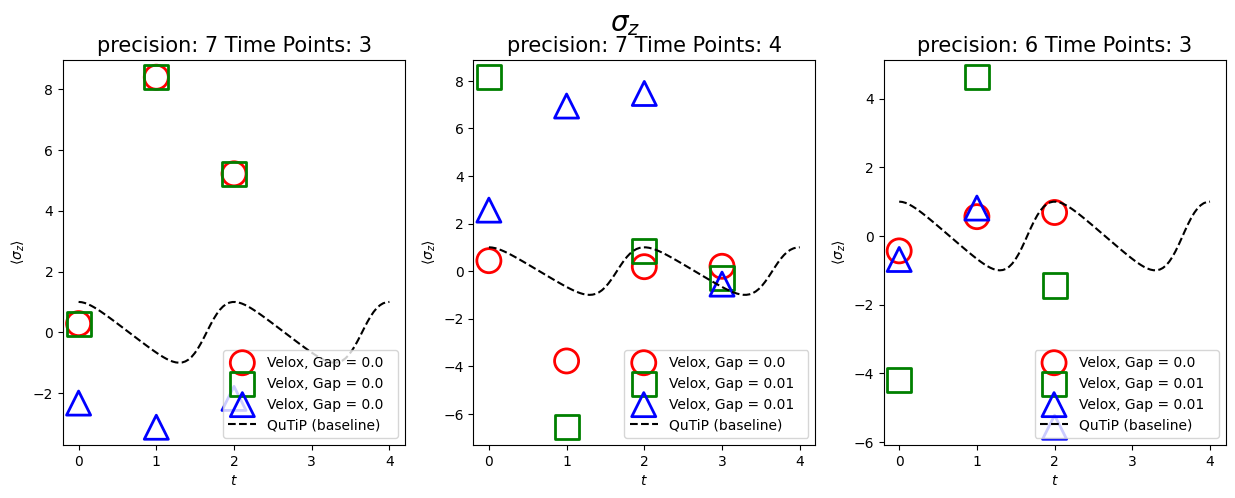

In [22]:

# Loop over all rows in velox_results and plot all dynamics on the same panel,
# coloring each curve according to its best_energy.
colors = ["r", "g", "b", "c", "m", "y", "k"]
markers = ["o", "s", "^", "D", "v", "<", ">"]

plot_rows =  1
plot_columns = 3
# Create a single axis for the plot
fig, axes = plt.subplots(plot_rows, plot_columns, figsize=(5*plot_columns, 5*plot_rows), sharey=False)

SZ = np.array([[1, 0], [0, -1]])  
axes = axes.flatten()
tp_pairs = [(7,3),(7,4),(6,3)]

for i, (precision,timepoints) in enumerate(tp_pairs):
    ax = axes[i]

    inst_obj = instance.Instance(system)

    inst_obj.create_instance(precision=precision,number_time_points=timepoints)
    qubo = inst_obj.get_qubo()


    df_filtered =  df_cleaned[(df_cleaned.precision == precision) & (df_cleaned.timepoints == timepoints)]
    for j in [0,1,2]:
        raw_sample = df_filtered['solution'].values[j][::-1]
        gap = round(df_filtered['gap'].values[j],ndigits=2)
        sample_str = helpers.result_string_to_dict(raw_sample)
        sample_vec = inst_obj.problem.interpret_sample(sample_str)
        exact_expect = [(state.conj() @ SZ @ state).real for state in sample_vec]
        ax.scatter(inst_obj.problem.times, exact_expect, color=colors[j % len(colors)], marker=markers[j % len(markers)], lw=2, s=300, facecolors="none", label=f"Velox, Gap = {gap}  ")


    psi_0 = qp.basis(2, 0)

    times = np.linspace(0, 4, 100)
    baseline = qp.mesolve(qp.Qobj(inst_obj.H), psi_0, times, e_ops=[qp.sigmaz()]).expect[0]
     

    # Difference d.: We use complex conjugation to compute expected values. For this example it shouldn't matter though.
    # Then, for the expectation values we take only the real part, because otherwise matplotlib would complain.
    ax.plot(times, baseline, "k--", label="QuTiP (baseline)")
    ax.set_title(f"precision: {precision} Time Points: {timepoints}",fontsize=15)

    ax.set_ylabel(r"$\langle \sigma_z \rangle$")
    ax.set_xlabel("$t$")
    ax.legend(loc="lower right")
fig.suptitle(r"$\sigma_z$",fontsize=20)
plt.show()

In [ ]:
system =1
inst_obj = instance.Instance(system)

inst_obj.create_instance(precision=2,number_time_points=2)
inst_obj.psi0 =1/np.sqrt(2)*np.array([1,1])
qubo = inst_obj.get_qubo()



[[ 2.+0.j  0.+0.j -0.+0.j -1.+0.j]
 [ 0.+0.j  2.+0.j  1.+0.j -0.+0.j]
 [-0.-0.j  1.-0.j  1.+0.j  0.+0.j]
 [-1.-0.j -0.-0.j  0.+0.j  1.+0.j]]
[[ 2.  0.  0.  0. -0.  0. -1.  0.]
 [-0.  2. -0.  0. -0. -0. -0. -1.]
 [ 0.  0.  2.  0.  1.  0. -0.  0.]
 [-0.  0. -0.  2. -0.  1. -0. -0.]
 [-0. -0.  1. -0.  1.  0.  0.  0.]
 [ 0. -0.  0.  1. -0.  1. -0.  0.]
 [-1. -0. -0. -0.  0.  0.  1.  0.]
 [ 0. -1.  0. -0. -0.  0. -0.  1.]]


In [ ]:
#dw_sampler = EmbeddingComposite(DWaveSampler( solver="Advantage2_prototype2.6"))
dw_sampler = EmbeddingComposite(DWaveSampler(solver="Advantage_system6.4"))

dw_result = dw_sampler.sample(qubo, num_reads=1, annealing_time=200)
dwave.inspector.show(dw_result)

Serving Inspector on http://127.0.0.1:18000/?problemId=c193993b-2e1c-4987-9321-33e96e47e42c

'http://127.0.0.1:18000/?problemId=c193993b-2e1c-4987-9321-33e96e47e42c'

In [18]:
dw_result.info

{'timing': {'qpu_sampling_time': 332120.0,
  'qpu_anneal_time_per_sample': 200.0,
  'qpu_readout_time_per_sample': 111.54,
  'qpu_access_time': 348045.56,
  'qpu_access_overhead_time': 2112.44,
  'qpu_programming_time': 15925.56,
  'qpu_delay_time_per_sample': 20.58,
  'post_processing_overhead_time': 1.0,
  'total_post_processing_time': 1.0},
 'problem_id': '25c4564f-3392-479b-bed7-01de674fde5b',
 'embedding_context': {'embedding': {1: (698,),
   0: (4563,),
   126: (4578,),
   127: (713,),
   3: (1016,),
   2: (5029,),
   124: (1001,),
   125: (5014,),
   5: (5108,),
   4: (1616,),
   68: (5123,),
   69: (1601,),
   7: (1349,),
   6: (5647,),
   70: (1334,),
   71: (5662,),
   9: (96,),
   8: (4170,),
   72: (111,),
   73: (4185,),
   11: (1042,),
   10: (4385,),
   74: (1027,),
   75: (4400,),
   13: (3736,),
   12: (3721,),
   76: (438,),
   77: (423,),
   15: (575,),
   14: (590,),
   78: (3917,),
   79: (3902,),
   17: (3606,),
   16: (3621,),
   80: (1323,),
   81: (1338,),
   1

In [50]:
times = np.linspace(0, inst_obj.number_time_points, 100)
baseline = qp.mesolve(qp.Qobj(inst_obj.H), qp.Qobj(inst_obj.psi0), times, e_ops=[qp.sigmaz()]).expect[0]

# Define sigma_z for manual computation of expected values
SZ = np.array([[1, 0], [0, -1]])

dw_vec = inst_obj.problem.interpret_sample(dw_result.first.sample)
dw_expect = [(state.conj() @ SZ @ state).real for state in dw_vec]
from matplotlib import pyplot as plt

fig, axis = plt.subplots(figsize=(8, 4))

axis.plot(times, baseline, "k--", label="QuTiP (baseline)")

#axis.scatter(inst_obj.problem.times, exact_expect, marker="^", lw=2, s=300, edgecolors="b", facecolors="none", label="Exact solver")
#axis.scatter(problem.times, sa_expect, marker="o", lw=2, s=100, edgecolors="r", facecolors="none", label="SA sampler")
axis.scatter(inst_obj.problem.times, dw_expect, marker="s", lw=2, s=200, edgecolors="g", facecolors="none", label="D-Wave sampler")
axis.set_title(f"System {system}")
axis.set_ylabel(r"$\langle \sigma_z \rangle$")
axis.set_xlabel("$t$")
axis.legend()

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 3)

In [48]:
inst_obj.problem.interpret_sample(dw_result.first.sample)

array([[ 1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j],
       [-1.+0.j,  1.+0.j],
       [-1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j],
       [ 1.+0.j,  0.+0.j],
       [ 0.+0.j,  1.+0.j],
       [-1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j],
       [ 1.+0.j,  0.+0.j]])

-------
sigma_y
---------
---------
array([[ 0.54030231+0.j, -0.84147098+0.j],
       [ 0.84147098+0.j,  0.54030231+0.j]])
------
array([[ 2.        +0.j,  0.        +0.j, -0.54030231+0.j,
        -0.84147098+0.j],
       [ 0.        +0.j,  2.        +0.j,  0.84147098+0.j,
        -0.54030231+0.j],
       [-0.54030231-0.j,  0.84147098-0.j,  1.        +0.j,
         0.        +0.j],
       [-0.84147098-0.j, -0.54030231-0.j,  0.        +0.j,
         1.        +0.j]])
-------
sigma_y
---------
---------
array([[ 0.54030231+0.j, -0.84147098+0.j],
       [ 0.84147098+0.j,  0.54030231+0.j]])
------
---------
array([[ 0.54030231+0.j, -0.84147098+0.j],
       [ 0.84147098+0.j,  0.54030231+0.j]])
------
array([[ 2.        +0.j,  0.        +0.j, -0.54030231+0.j,
        -0.84147098+0.j,  0.        +0.j,  0.        +0.j],
       [ 0.        +0.j,  2.        +0.j,  0.84147098+0.j,
        -0.54030231+0.j,  0.        +0.j,  0.        +0.j],
       [-0.54030231-0.j,  0.84147098-0.j,  2.        +0.j

Text(0.5, 1.0, 'Density for system 8')

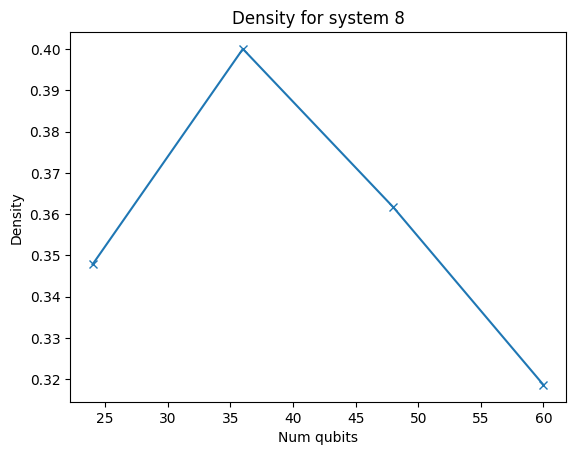

In [56]:
system = 8
inst = instance.Instance(system)
interactions = []
max_interactions = []
num_qubits = []
for timepoints in range(2,10):
    inst.create_instance(precision=3, number_time_points=timepoints)
    vertices = inst.qubo.num_variables
    if vertices > 60:
        break
    interactions.append(inst.qubo.num_interactions)
    num_qubits.append(vertices)
    max_int = (vertices * (vertices-1))/2
    max_interactions.append(max_int)

plt.plot(num_qubits, np.array(interactions)/np.array(max_interactions),marker='x')
plt.ylabel('Density')
plt.xlabel('Num qubits')
plt.title(f"Density for system {ſystem}")

In [57]:
print(max_interactions)

[276.0, 630.0, 1128.0, 1770.0]


In [59]:
print(interactions)

[96, 252, 408, 564]
